In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import corner
import dynesty
from dynesty import plotting as dyplot

In [2]:
#Get the data 
data = np.load('../solutions/transient.npy')
print(data[:10, :]) #Print the first ten terms

[[ 0.46954762  8.83485016  1.        ]
 [ 1.87898004 10.90082649  1.        ]
 [ 2.01075462 10.46566244  1.        ]
 [ 2.02183974  8.46375631  1.        ]
 [ 3.91877923 11.48825219  1.        ]
 [ 6.02254716 11.89588918  1.        ]
 [ 6.41474963 11.17877957  1.        ]
 [ 7.10360582  9.82007516  1.        ]
 [ 8.71292997  8.92924738  1.        ]
 [ 9.39405108 11.05445173  1.        ]]


In [3]:
def burst(par, x): 
    t_0, b, A, alpha = par
    return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))

In [4]:
def logL(par, model = burst): 
    x, y, yerr = data.T
    return -0.5 * np.sum(np.power((y - model(par, x)) / yerr, 2))

In [5]:
#Set the ranges for the priors
t_0min,t_0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [6]:
def prior_transform(u):
    #u is an array of 4 values in [0, 1]
    t_0 = t_0min + u[0] * (t_0max - t_0min)
    b   = bmin   + u[1] * (bmax - bmin)
    A   = Amin   + u[2] * (Amax - Amin)
    #For alpha, use log-uniform prior
    log_alpha = np.log(alphamin) + u[3] * (np.log(alphamax) - np.log(alphamin))
    alpha = np.exp(log_alpha)
    return np.array([t_0, b, A, alpha])

In [7]:
#Perform a nested sampling
ndim = 4
sampler = dynesty.NestedSampler(logL, prior_transform, ndim)
sampler.run_nested()
sresults = sampler.results

/tmp/ipykernel_10791/3411230673.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))
/tmp/ipykernel_10791/3411230673.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))
1765it [00:02, 446.22it/s, bound: 0 | nc: 20 | ncall: 16861 | eff(%): 10.468 | loglstar:   -inf < -175.885 <    inf | logz: -184.978 +/-  0.124 | dlogz: 119.981 >  0.509]   /tmp/ipykernel_10791/3411230673.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))
/tmp/ipykernel_10791/3411230673.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))
1904it [00:02, 311.66it/s, bound: 1 | nc: 21 | ncall: 18581 | eff(%): 10.247 | loglstar:   -inf < -144.810 <    inf | logz: -153.294 +/-  0.121 | dlogz: 87.757 >  0.509] /tmp/ipykernel_10791/3411230673.py:3: RuntimeWarning: o

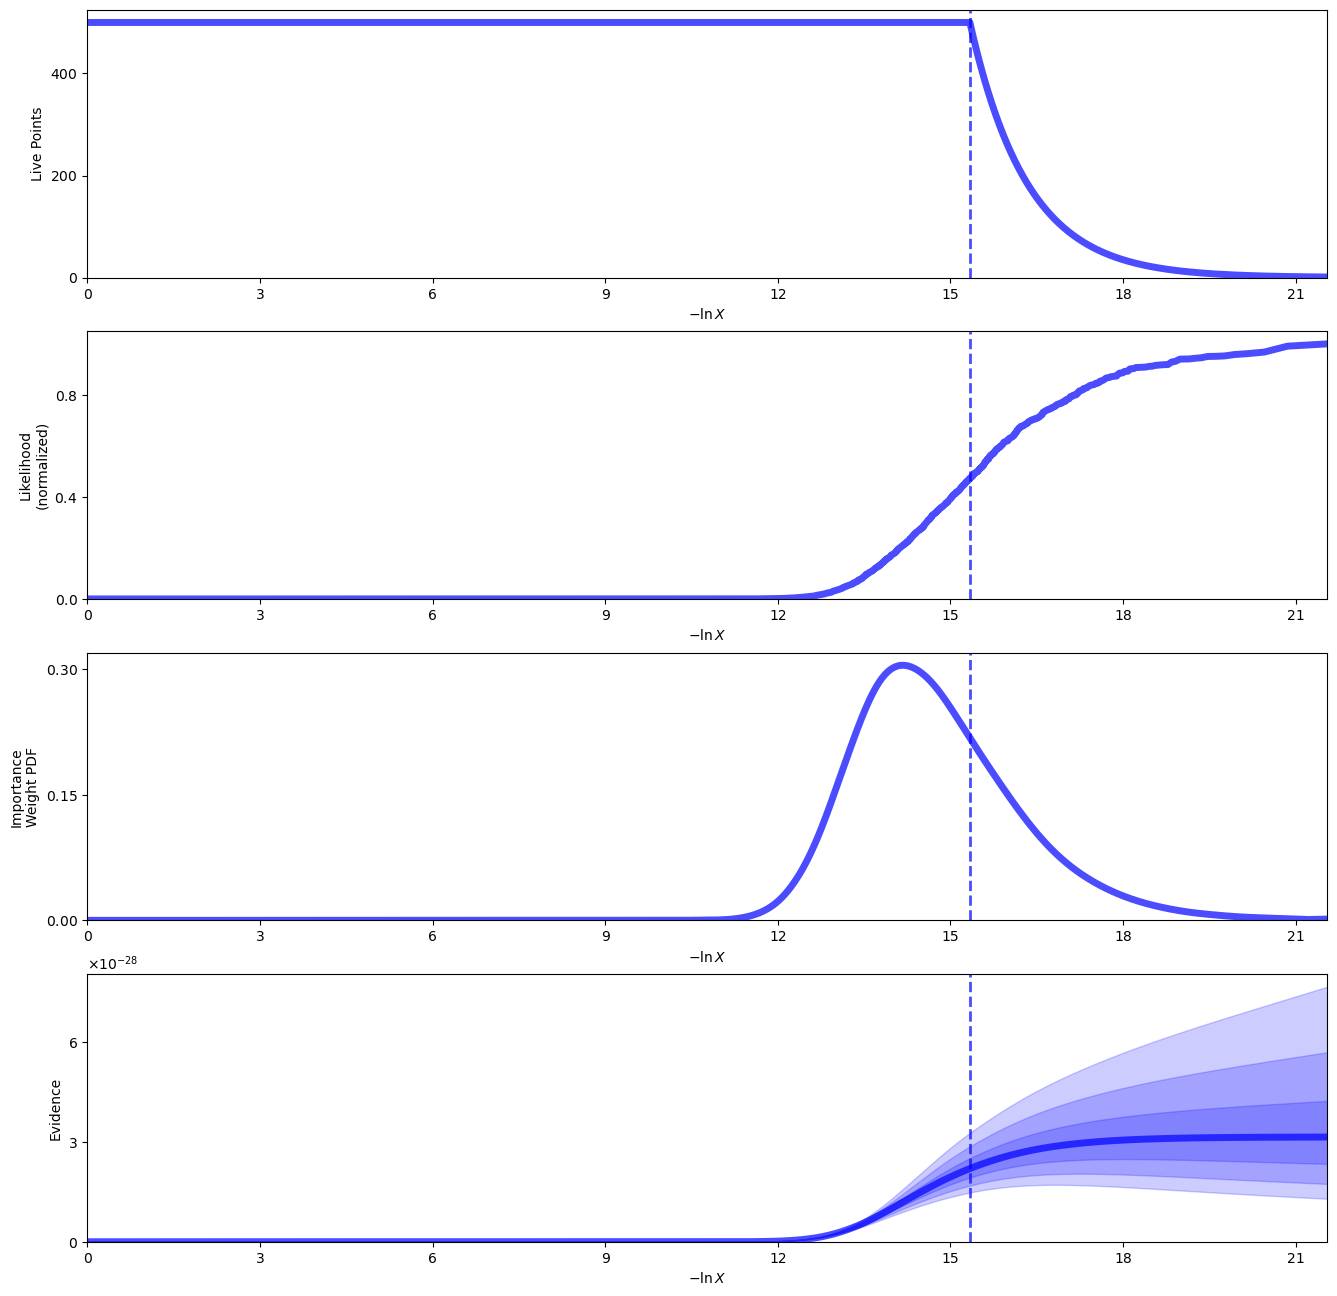

In [8]:
#Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)

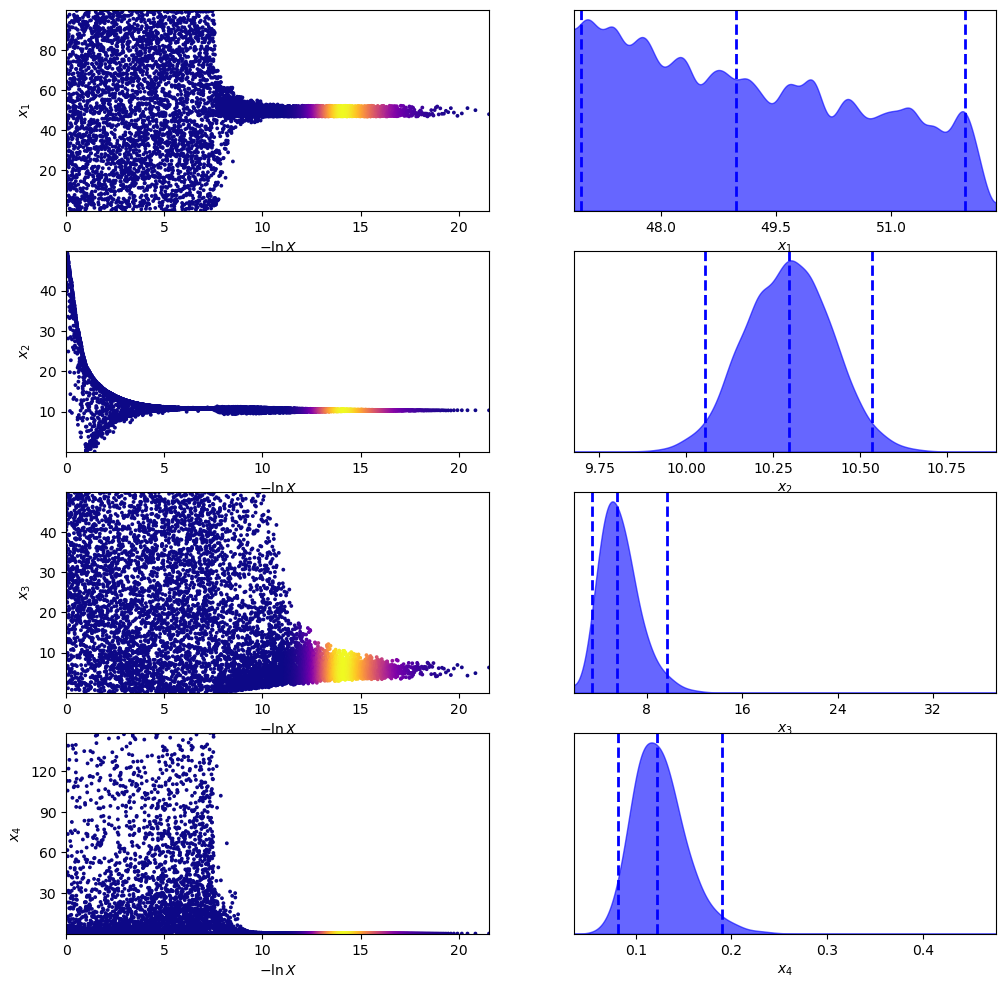

In [9]:
tfig, taxes = dyplot.traceplot(sresults)

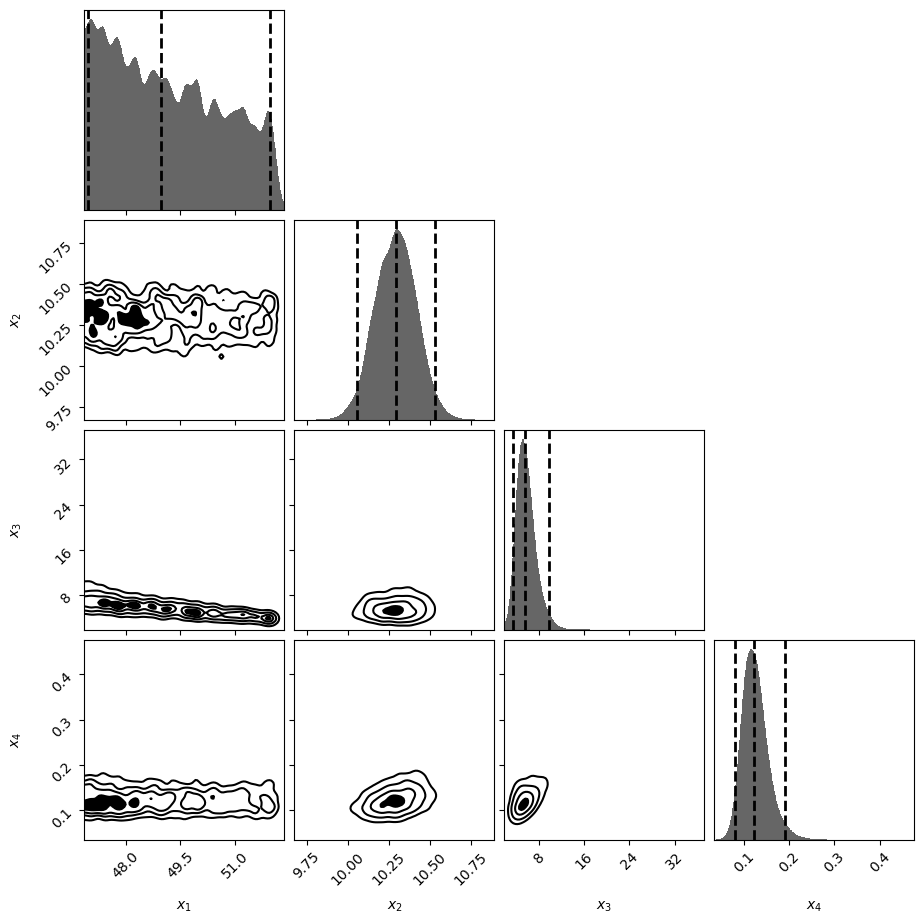

In [10]:
cfig, caxes = dyplot.cornerplot(sresults)

In [11]:
from dynesty import utils as dyfunc


#Extract sampling results
samples = sresults.samples  #samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  #normalised weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

#Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

#Compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 3.1510484197057347e-28
68% parameter credible regions are:
 [[47.43275289310866, 50.9990200825953], [10.16794346987585, 10.415848335140877], [4.253086525042195, 7.2595540467333235], [0.09911456338932026, 0.15100318217665284]]

Mean and covariance of parameters are: [49.15242812 10.29292721  5.76476783  0.1253953 ]
[[ 2.32509957e+00 -5.99767579e-03 -1.65274960e+00 -9.24165303e-04]
 [-5.99767579e-03  1.52010236e-02  1.87631387e-02  1.37503473e-03]
 [-1.65274960e+00  1.87631387e-02  2.63069354e+00  2.58702620e-02]
 [-9.24165303e-04  1.37503473e-03  2.58702620e-02  7.73408037e-04]]


In [12]:
#Save the bayesian evidence
b_evidence=[]
b_evidence.append(np.exp(evidence))

Let's see the second model

In [13]:
def gauss(par, x): 
    t_0, b, A, sigma_W = par
    return b + A * np.exp(- (x - t_0)**2 / (2 * sigma_W**2))

In [14]:
#Set the remaining range
sigma_Wmin,sigma_Wmax=0.1,20

In [15]:
def prior_transform2(u):
    #u is an array of 4 values in [0, 1]
    t_0 = t_0min + u[0] * (t_0max - t_0min)
    b   = bmin   + u[1] * (bmax - bmin)
    A   = Amin   + u[2] * (Amax - Amin)
    sigma_W = sigma_Wmin + u[3] * (sigma_Wmax - sigma_Wmin)
    return np.array([t_0, b, A, sigma_W])

In [16]:
#Perform a nested sampling
ndim = 4
sampler = dynesty.NestedSampler(lambda par: logL(par, model=gauss), prior_transform2, ndim)
sampler.run_nested()
sresults = sampler.results

0it [00:00, ?it/s]

4022it [00:21, 77.28it/s, bound: 37 | nc: 480 | ncall: 45116 | eff(%):  8.915 | loglstar:   -inf < -87.156 <    inf | logz: -96.675 +/-  0.131 | dlogz: 34.777 >  0.509]      /home/morgan/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4129it [00:23, 90.62it/s, bound: 41 | nc: 24 | ncall: 48265 | eff(%):  8.555 | loglstar:   -inf < -85.035 <    inf | logz: -95.392 +/-  0.134 | dlogz: 33.288 >  0.509] /home/morgan/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large

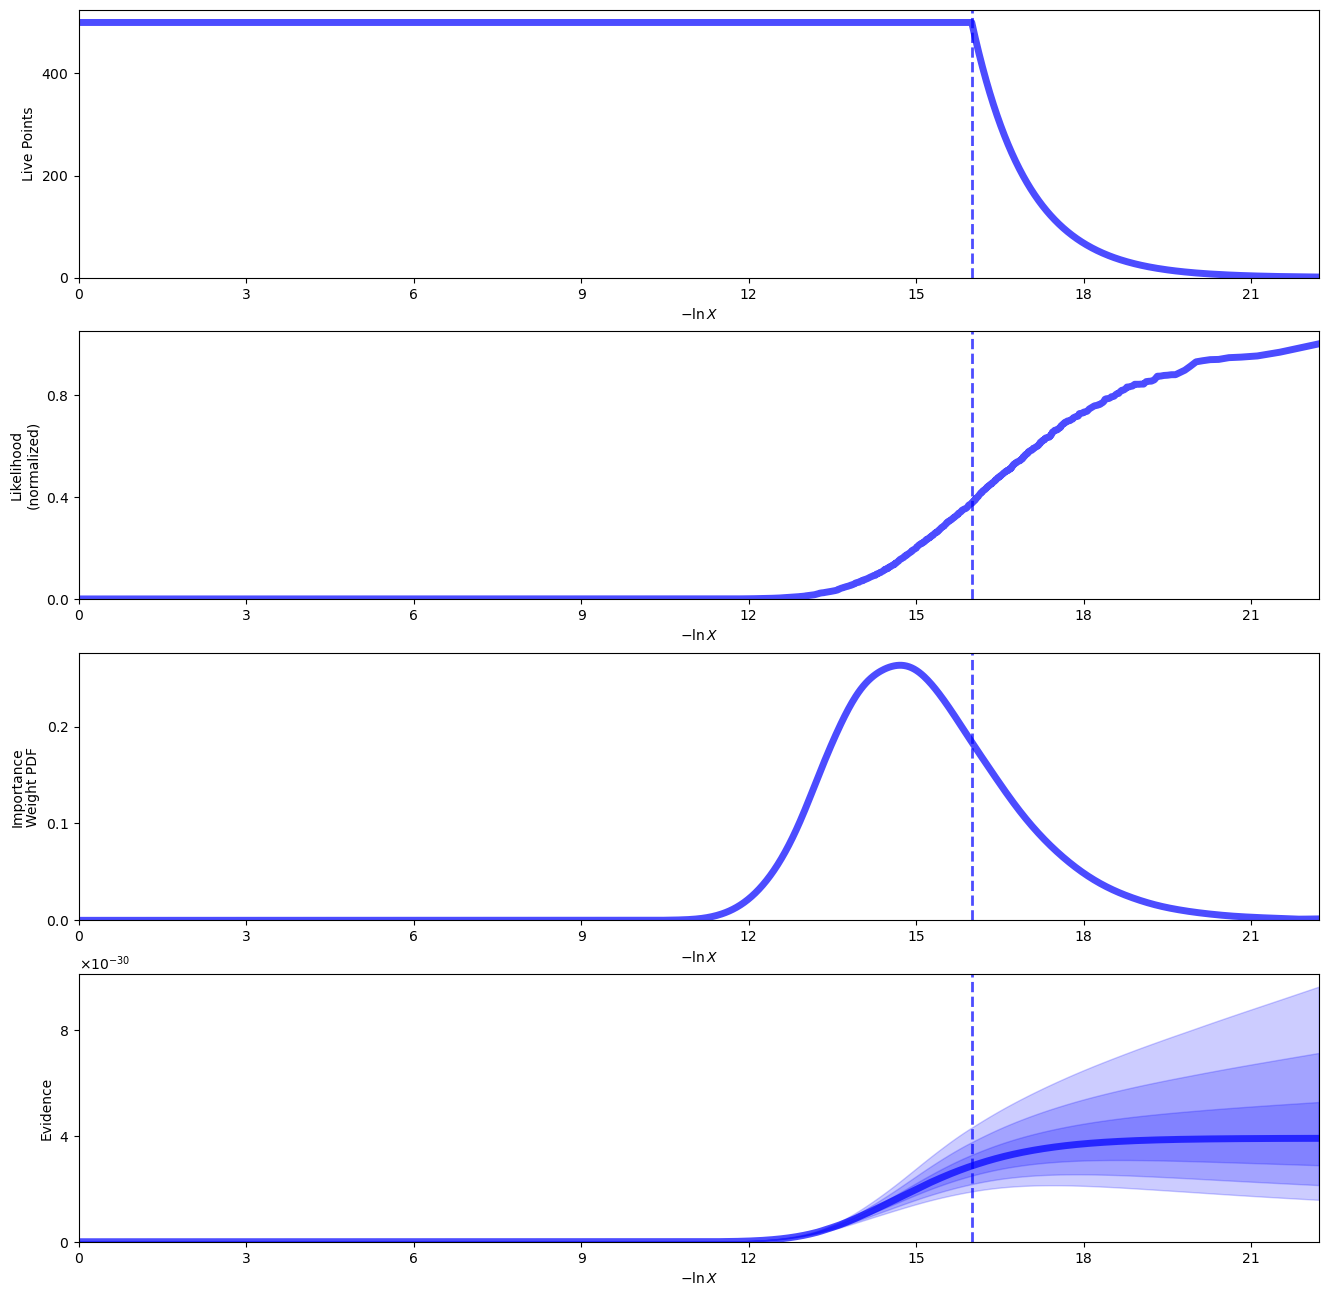

In [17]:
#Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)

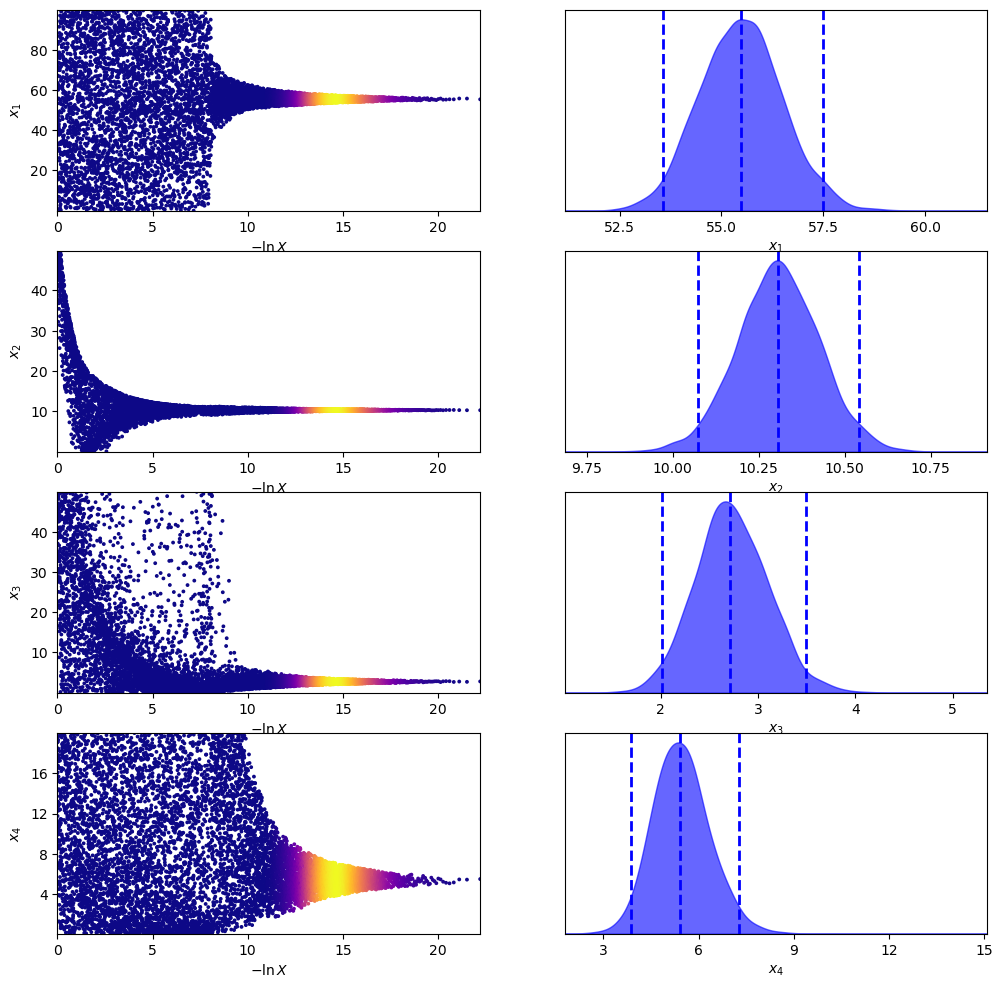

In [18]:
tfig, taxes = dyplot.traceplot(sresults)

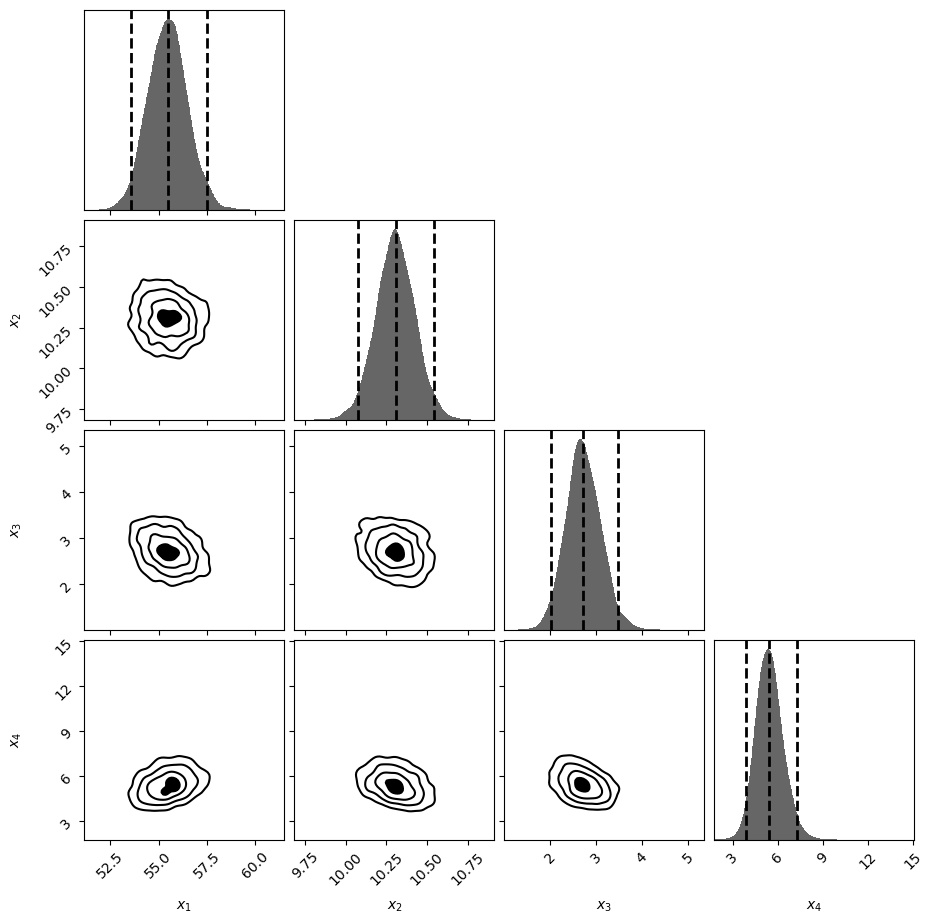

In [19]:
cfig, caxes = dyplot.cornerplot(sresults)

In [20]:
#Extract sampling results
samples = sresults.samples  #samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  #normalised weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

#Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

#Compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 3.903179494943505e-30
68% parameter credible regions are:
 [[54.462387156473596, 56.45574786310281], [10.193507831367478, 10.423047039927985], [2.3666023677504735, 3.099085897537545], [4.599199607972898, 6.305895228719622]]

Mean and covariance of parameters are: [55.47776099 10.30672386  2.73038627  5.45248598]
[[ 1.00857652 -0.01537784 -0.12505106  0.28354152]
 [-0.01537784  0.01409514 -0.01027656 -0.03673616]
 [-0.12505106 -0.01027656  0.1394495  -0.14095967]
 [ 0.28354152 -0.03673616 -0.14095967  0.78200569]]


In [21]:
b_evidence.append(np.exp(evidence))

In [22]:
print("Bayes factor (Gaussian/burst):", b_evidence[1]/b_evidence[0])
print("The favourite model is the burst model")

Bayes factor (Gaussian/burst): 0.012386923255555715
The favourite model is the burst model
